##### 1. Установим нужные библиотеки

In [31]:
# %pip install mlxtend==0.23.0

In [68]:
import os

import psycopg
import pandas as pd
import numpy as np
import mlflow
from autofeat import AutoFeatClassifier
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    log_loss,
    get_scorer_names,
)
import matplotlib.pyplot as plt

##### 1. Определим глобальные перменные

In [124]:
TABLE_NAME = "users_churn"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_nikolaistepanov"
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = "churn_model_nikolaistepanov_prepared"
FS_ASSETS = "fs_assets"

In [78]:
os.mkdir(FS_ASSETS)

In [34]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

##### 2. Заберем данные из базы данных и сформируем `dataframe`

In [35]:
connection = {"sslmode": "verify-full", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("POSTGRES_HOST"),
    "port": os.getenv("POSTGRES_PORT"),
    "dbname": os.getenv("POSTGRES_DBNAME"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"),
}

connection.update(postgres_credentials)

In [36]:
with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

##### 3. Разделим данные на train, test по `begin_date`

In [37]:
cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]

features = cat_features + num_features
target = "target"

split_column = "begin_date"
stratify_column = ["type"]
test_size = 0.2

In [38]:
df = df.sort_values(by=[split_column])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=test_size,
    shuffle=False,
)

In [40]:
print(f"Размер выборки для обучения: {X_train.shape}")
print(f"Размер выборки для теста: {X_test.shape}")

Размер выборки для обучения: (5634, 16)
Размер выборки для теста: (1409, 16)


##### 4. Определим список трансформаций к нашим признакам

In [41]:
transformations = (
    "1/", "1+", "1-", 
    'exp', 'log', 'abs', 'sqrt',
    "2^"
)

##### 5. Запустим генератор признаков

In [42]:
afc = AutoFeatClassifier(
    categorical_cols=cat_features,
    transformations=transformations,
    feateng_steps=1,
    n_jobs=-1
)

In [43]:
%%time


X_train_features = afc.fit_transform(X_train, y_train)

CPU times: user 8.56 s, sys: 1.25 s, total: 9.82 s
Wall time: 8.23 s


In [48]:
X_train_features.head(2)

,monthly_charges,total_charges,cat_paperless_billing_0,cat_paperless_billing_1,cat_payment_method_Bank transfer (automatic),cat_payment_method_Credit card (automatic),cat_payment_method_Electronic check,cat_payment_method_Mailed check,cat_internet_service_DSL,cat_internet_service_Fiber optic,cat_internet_service_No data,cat_online_security_0,cat_online_security_1,cat_online_backup_0,cat_online_backup_1,cat_device_protection_0,cat_device_protection_1,cat_tech_support_0,cat_tech_support_1,cat_streaming_tv_0,cat_streaming_tv_1,cat_streaming_movies_0,cat_streaming_movies_1,cat_gender_Female,cat_gender_Male,cat_senior_citizen_0,cat_senior_citizen_1,cat_partner_0,cat_partner_1,cat_dependents_0,cat_dependents_1,cat_multiple_lines_0,cat_multiple_lines_1
0,104.15,7689.95,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,117.8,8684.8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [50]:
X_train_features.shape

(5634, 33)

In [49]:
X_test_features = afc.transform(X_test)

##### 5. Определим алгоритмы отбора признаков. Рассмотрим два:
- Sequential Forward Selection
- Sequential Backward Selection

In [56]:
# get_scorer_names()

In [57]:
estimator = RandomForestClassifier(n_estimators=300)

sfs = SFS(estimator, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='roc_auc',
          cv=4,
          n_jobs=-1)

sbs = SFS(estimator, 
          k_features=10, 
          forward=False, 
          floating=False, 
          scoring='roc_auc',
          cv=4,
          n_jobs=-1)

In [58]:
%%time


sfs = sfs.fit(X_train_features, y_train)

CPU times: user 2.88 s, sys: 507 ms, total: 3.38 s
Wall time: 1min 18s


In [95]:
top_sfs = sfs.k_feature_names_

In [60]:
print('\nSequential Forward Selection (k=10):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=10):
(6, 9, 10, 12, 15, 16, 17, 18, 27, 28)
CV Score:
0.797989699588676


In [62]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [81]:
sfs_df.head(1)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.6912533814247068, 0.6973880372708146, 0.699...",0.699565,"(cat_internet_service_Fiber optic,)",0.011021,0.006875,0.00397


In [82]:
sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")

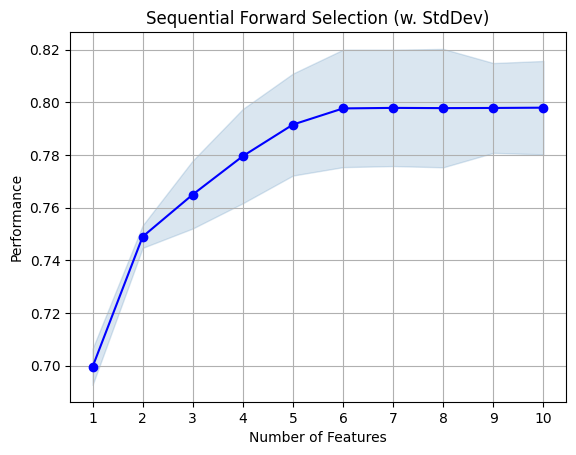

<Figure size 640x480 with 0 Axes>

In [80]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png")

In [59]:
%%time


sbs = sbs.fit(X_train_features, y_train)

CPU times: user 8.17 s, sys: 1.03 s, total: 9.2 s
Wall time: 5min 5s


In [94]:
top_sbs = sbs.k_feature_names_

In [61]:
print('\nSequential Backward Selection (k=10):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)


Sequential Backward Selection (k=10):
(0, 2, 6, 12, 14, 16, 17, 21, 24, 27)
CV Score:
0.7404813300230413


In [71]:
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

In [83]:
sbs_df.head(1)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
33,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7429861737300872, 0.6265314096783888, 0.673...",0.711538,"(monthly_charges, total_charges, cat_paperless...",0.107927,0.067329,0.038872


In [84]:
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

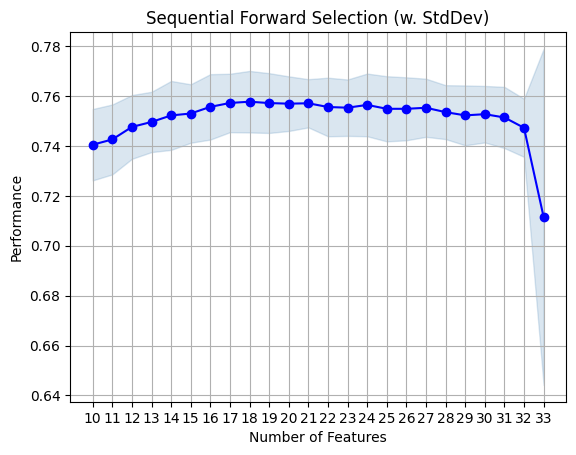

<Figure size 640x480 with 0 Axes>

In [79]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig("FS_ASSETS/sbs.png")

##### 4.1. Сравним отобранные признаки от двух подходов

In [104]:
interc_features = list(set(top_sbs) & set(tob_sfs))

In [105]:
interc_features

['cat_device_protection_1',
 'cat_partner_0',
 'cat_tech_support_0',
 'cat_online_security_1',
 'cat_payment_method_Electronic check']

In [106]:
union_features = list(set(top_sbs) | set(tob_sfs))

In [107]:
union_features

['cat_device_protection_1',
 'cat_internet_service_Fiber optic',
 'cat_tech_support_1',
 'cat_partner_1',
 'cat_streaming_movies_0',
 'cat_tech_support_0',
 'cat_online_backup_1',
 'cat_online_security_1',
 'cat_payment_method_Electronic check',
 'cat_partner_0',
 'cat_internet_service_No data',
 'monthly_charges',
 'cat_device_protection_0',
 'cat_paperless_billing_0',
 'cat_gender_Male']

##### 5. Обучим модель на отоборанных признаков признаках (для обоих случаев)

In [112]:
loss_function = "Logloss"
task_type = 'CPU'
random_seed = 0
iterations = 400
verbose = False
max_depth=3

model_interc = CatBoostClassifier(
    iterations=iterations, 
    loss_function=loss_function, 
    random_seed=random_seed, 
    task_type=task_type,
    verbose=verbose,
    max_depth=max_depth
)

model_union = CatBoostClassifier(
    iterations=iterations, 
    loss_function=loss_function, 
    random_seed=random_seed, 
    task_type=task_type,
    verbose=verbose,
    max_depth=max_depth
)

In [113]:
%%time

model_interc.fit(X_train_features[interc_features], y_train)

CPU times: user 389 ms, sys: 365 ms, total: 753 ms
Wall time: 330 ms


In [114]:
%%time

model_union.fit(X_train_features[union_features], y_train)

CPU times: user 506 ms, sys: 538 ms, total: 1.04 s
Wall time: 405 ms


In [118]:
%%time

prediction_interc = model_interc.predict(X_test_features[interc_features])
probas_interc = model_interc.predict_proba(X_test_features[interc_features])[:, 1]

CPU times: user 10.9 ms, sys: 3.93 ms, total: 14.8 ms
Wall time: 8.47 ms


In [120]:
%%time

prediction_union = model_union.predict(X_test_features[union_features])
probas_union = model_union.predict_proba(X_test_features[union_features])[:, 1]

CPU times: user 13.8 ms, sys: 3.48 ms, total: 17.2 ms
Wall time: 10.2 ms


##### 6. Посчитаем метрики и залогируем в `MLFlow` оба варианта

In [121]:
metrics_interc = {}

_, err1, _, err2 = confusion_matrix(y_test, prediction_interc, normalize='all').ravel()
auc = roc_auc_score(y_test, probas)
precision = precision_score(y_test, prediction_interc)
recall = recall_score(y_test, prediction_interc)
f1 = f1_score(y_test, prediction_interc)
logloss = log_loss(y_test, prediction_interc)

metrics_interc["err1"] = err1
metrics_interc["err2"] = err2
metrics_interc["auc"] = auc
metrics_interc["precision"] = precision
metrics_interc["recall"] = recall
metrics_interc["f1"] = f1
metrics_interc["logloss"] = logloss


metrics_union = {}

_, err1, _, err2 = confusion_matrix(y_test, prediction_union, normalize='all').ravel()
auc = roc_auc_score(y_test, probas_union)
precision = precision_score(y_test, prediction_union)
recall = recall_score(y_test, prediction_union)
f1 = f1_score(y_test, prediction_union)
logloss = log_loss(y_test, prediction_union)

metrics_union["err1"] = err1
metrics_union["err2"] = err2
metrics_union["auc"] = auc
metrics_union["precision"] = precision
metrics_union["recall"] = recall
metrics_union["f1"] = f1
metrics_union["logloss"] = logloss

In [122]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "..."
os.environ["AWS_ACCESS_KEY_ID"] = "..."
os.environ["AWS_SECRET_ACCESS_KEY"] = "..."

In [123]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [127]:
pip_requirements="../requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[interc_features], prediction_interc)
input_example = X_test_features[interc_features][:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics_interc)
    mlflow.log_artifacts(FS_ASSETS)
    model_info = mlflow.catboost.log_model(
        cb_model=model_interc, 
        artifact_path="models",
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements,
    )

/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'churn_model_nikolaistepanov_prepared' already exists. Creating a new version of this model...
2023/11/01 14:08:06 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_ni

In [128]:
pip_requirements="../requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[union_features], prediction_union)
input_example = X_test_features[union_features][:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics_union)
    mlflow.log_artifacts(FS_ASSETS)
    model_info = mlflow.catboost.log_model(
        cb_model=model_union, 
        artifact_path="models",
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements,
    )

/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'churn_model_nikolaistepanov_prepared' already exists. Creating a new version of this model...
2023/11/01 14:08:34 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_ni